
The objective is to learn an end-to-end mapping from raw multivariate time-series process signals to a continuous quality indicator (opening distance) using a 1D Convolutional Neural Network.



In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, ReLU,
    GlobalAveragePooling1D, Dense, Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [8]:
X_dict = np.load("../dataset/synthetic/X_dict.npy", allow_pickle=True).item()
y_dict = np.load("../dataset/synthetic/y_dict.npy", allow_pickle=True).item()

X = np.stack([
    X_dict["InjectionPressure"],
    X_dict["RamPosition"],
    X_dict["CavityPressure"]
], axis=-1)   # (N, 200, 3)

y = y_dict["opening"].reshape(-1,)


In [34]:
print(X_dict)

{'InjectionPressure': array([[       0.        , 14052895.97481189, 16337959.64051332, ...,
               0.        ,        0.        ,        0.        ],
       [       0.        , 13089899.65285886, 15530795.22888444, ...,
               0.        ,        0.        ,        0.        ],
       [       0.        , 14141635.76441103, 17151720.25626327, ...,
               0.        ,        0.        ,        0.        ],
       ...,
       [       0.        , 16600819.54449442, 19323365.33593186, ...,
               0.        ,        0.        ,        0.        ],
       [       0.        , 14252333.94023174, 16820382.76435122, ...,
               0.        ,        0.        ,        0.        ],
       [       0.        , 12028682.24698999, 14306158.46173936, ...,
               0.        ,        0.        ,        0.        ]],
      shape=(3147, 200)), 'RamPosition': array([[0.07179924, 0.06751034, 0.06322044, ..., 0.0048359 , 0.0048359 ,
        0.0048359 ],
       [0.0717

In [35]:
print(y_dict)

{'weight': array([[21.6977],
       [21.6539],
       [21.6579],
       ...,
       [21.6626],
       [21.7427],
       [21.6805]], shape=(3147, 1)), 'opening': array([[52.236397],
       [52.26641 ],
       [52.261106],
       ...,
       [52.196756],
       [52.246343],
       [52.21381 ]], shape=(3147, 1)), 'valid': array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], shape=(3147, 1), dtype=int32)}


In [9]:
print(X.shape, y.shape)
# (3147, 200, 3) (3147,)


(3147, 200, 3) (3147,)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [11]:
X_mean = X_train.mean(axis=(0,1), keepdims=True)
X_std  = X_train.std(axis=(0,1), keepdims=True)

X_train_n = (X_train - X_mean) / X_std
X_test_n  = (X_test  - X_mean) / X_std


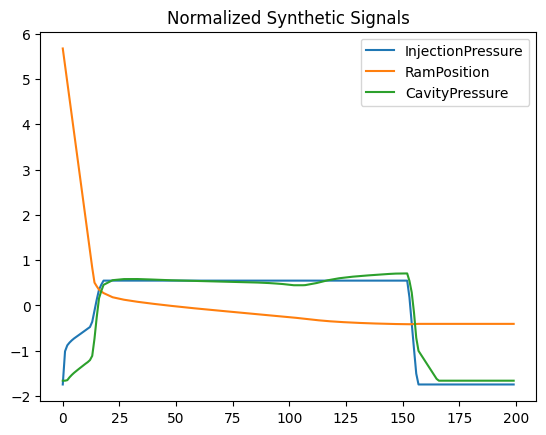

In [12]:
plt.plot(X_train_n[0,:,0], label="InjectionPressure")
plt.plot(X_train_n[0,:,1], label="RamPosition")
plt.plot(X_train_n[0,:,2], label="CavityPressure")
plt.legend()
plt.title("Normalized Synthetic Signals")
plt.show()


In [13]:
y_mean = y_train.mean()
y_std  = y_train.std()

y_train_n = (y_train - y_mean) / y_std
y_test_n  = (y_test  - y_mean) / y_std


In [14]:
print("y_train mean/std:", y_train.mean(), y_train.std())
print("y_train_n mean/std:", y_train_n.mean(), y_train_n.std())


y_train mean/std: 52.25427685299961 0.03512299189922415
y_train_n mean/std: -2.1234839252275875e-13 1.0


In [15]:
def build_cnn(input_shape):
    inp = Input(shape=input_shape)

    x = Conv1D(32, 5, padding="same")(inp)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv1D(64, 5, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv1D(128, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.3)(x)

    out = Dense(1, activation="linear")(x)
    return Model(inp, out)


In [16]:
tf.keras.backend.clear_session()

model = build_cnn((X.shape[1], X.shape[2]))
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="mse"
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 200, 32)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 200, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 200, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 200, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 200, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 200, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,737 (174.75 KB)

 Trainable params: 44,289 (173.00 KB)

 Non-trainable params: 448 (1.75 KB)

In [17]:
es = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train_n,
    y_train_n,          # ← MUST be normalized y
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=1
)


Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.7596 - val_loss: 1.0007
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.4930 - val_loss: 0.8174
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.3836 - val_loss: 1.1712
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.2662 - val_loss: 2.3917
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.2327 - val_loss: 2.2908
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1949 - val_loss: 0.1799
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1861 - val_loss: 1.0871
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1755 - val_loss: 0.1946
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1834 - val_loss: 0.5812
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1905 - val_loss: 1.0770
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1486 - val_loss: 0.2261
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step

In [18]:
y_pred_n = model.predict(X_test_n).ravel()
y_pred   = y_pred_n * y_std + y_mean


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [19]:
print(y_pred.min(), y_pred.max(), y_pred.mean())


52.13890766938924 52.335635275913845 52.25435056778907


In [20]:
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² :", r2_score(y_test, y_pred))


MAE: 0.007001628577105548
R² : 0.9351110088092425


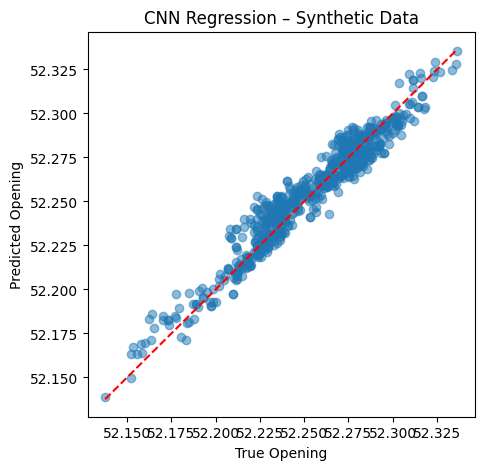

In [21]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("True Opening")
plt.ylabel("Predicted Opening")
plt.title("CNN Regression – Synthetic Data")
plt.show()


In [22]:
mean_train = y_train.mean()
std_train  = y_train.std()

lower = mean_train - 2 * std_train
upper = mean_train + 2 * std_train

qc_true = ((y_test >= lower) & (y_test <= upper)).astype(int)
qc_pred = ((y_pred >= lower) & (y_pred <= upper)).astype(int)

print("QC Accuracy:", accuracy_score(qc_true, qc_pred))
print(confusion_matrix(qc_true, qc_pred))
print(classification_report(qc_true, qc_pred))


QC Accuracy: 0.9841269841269841
[[ 21   7]
 [  3 599]]
              precision    recall  f1-score   support

           0       0.88      0.75      0.81        28
           1       0.99      1.00      0.99       602

    accuracy                           0.98       630
   macro avg       0.93      0.87      0.90       630
weighted avg       0.98      0.98      0.98       630



In [24]:
model.save("../models/cnn_synthetic_pretrained.keras")


# CNN Transfer Learning for Injection Moulding Quality Control



In [29]:
import numpy as np
import tensorflow as tf
import joblib
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from scipy.signal import resample

In [30]:
X_real = np.load("../dataset/real/X_real.npy",allow_pickle=True)
y_real = np.load("../dataset/real/y_real.npy",allow_pickle=True)
print(X_real.shape, y_real.shape)



(438, 181, 7) (438, 2)


In [32]:
qc_real_true = y_real[:, 0].astype(int)
y_real_opening = y_real[:, 1].reshape(-1, 1)

print(qc_real_true.shape, y_real_opening.shape)
# (438,) (438, 1)


(438,) (438, 1)


In [47]:
#print(X_real)

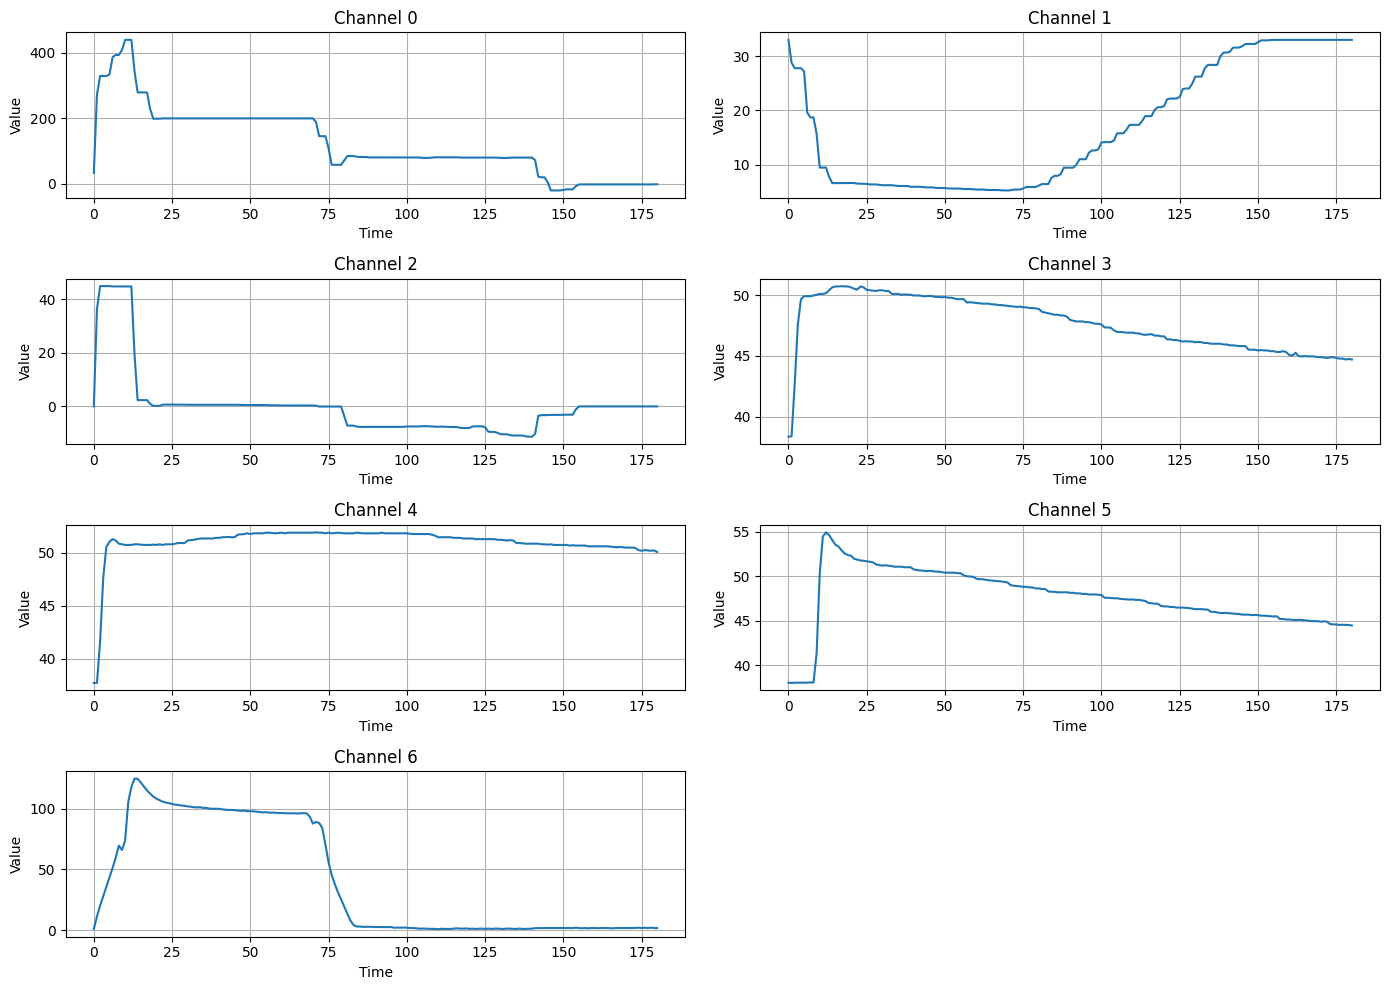

In [36]:
import matplotlib.pyplot as plt

sample_id = 0  # any sample
T = X_real.shape[1]
C = X_real.shape[2]

plt.figure(figsize=(14, 10))
for c in range(C):
    plt.subplot(4, 2, c + 1)
    plt.plot(X_real[sample_id, :, c])
    plt.title(f"Channel {c}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plt.tight_layout()
plt.show()


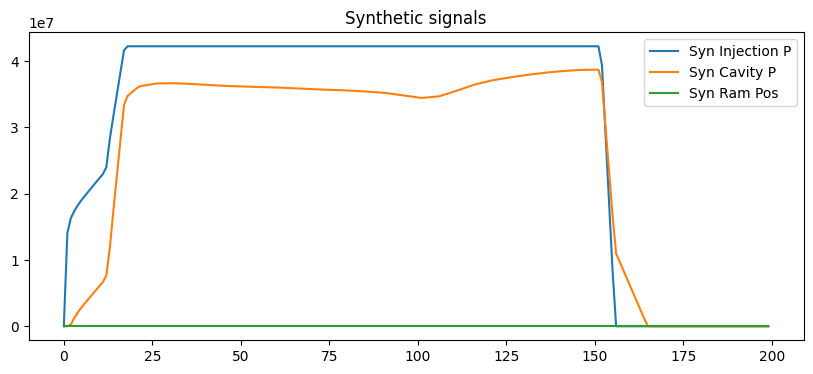

In [96]:
plt.figure(figsize=(10,4))
plt.plot(X_syn[0,:,0], label="Syn Injection P")
plt.plot(X_syn[0,:,1], label="Syn Cavity P")
plt.plot(X_syn[0,:,2], label="Syn Ram Pos")
plt.legend()
plt.title("Synthetic signals")
plt.show()

In [37]:
import pandas as pd

stats = []
for c in range(C):
    stats.append({
        "channel": c,
        "min": X_real[:, :, c].min(),
        "max": X_real[:, :, c].max(),
        "mean": X_real[:, :, c].mean(),
        "std": X_real[:, :, c].std()
    })

pd.DataFrame(stats)


,channel,min,max,mean,std
0,0,-55.332897,677.810730,160.080100,138.913090
1,1,3.632359,36.996063,16.946680,11.104472
2,2,-27.822613,70.034737,0.001901,11.926090
3,3,24.820000,74.010000,56.224142,6.941660
4,4,32.260000,96.040000,80.284838,8.186379
5,5,24.450000,76.390000,55.043153,7.126291
6,6,-2.930000,276.735000,71.181953,81.645486


In [40]:
print(X_dict.keys())
for k in X_dict.keys():
    print(
        k,
        "min:", X_dict[k].min(),
        "max:", X_dict[k].max(),
        "mean:", X_dict[k].mean()
    )


dict_keys(['InjectionPressure', 'RamPosition', 'CavityPressure'])
InjectionPressure min: 0.0 max: 44970000.0 mean: 29366370.89101962
RamPosition min: 0.003936129435255033 max: 0.07179970084218236 mean: 0.009587790646372793
CavityPressure min: 0.0 max: 41656520.7676391 mean: 24464608.71066576


In [41]:
X_syn = np.stack(
    [
        X_dict["InjectionPressure"],
        X_dict["CavityPressure"],
        X_dict["RamPosition"]
    ],
    axis=-1
)

print(X_syn.shape)
# (3147, 200, 3)


(3147, 200, 3)


In [42]:
for c, name in enumerate(["InjectionPressure", "CavityPressure", "RamPosition"]):
    print(
        f"Synthetic {name}:",
        "min:", X_syn[:, :, c].min(),
        "max:", X_syn[:, :, c].max()
    )


Synthetic InjectionPressure: min: 0.0 max: 44970000.0
Synthetic CavityPressure: min: 0.0 max: 41656520.7676391
Synthetic RamPosition: min: 0.003936129435255033 max: 0.07179970084218236


In [43]:
for c in range(7):
    print(
        f"Real channel {c}:",
        "min:", X_real[:, :, c].min(),
        "max:", X_real[:, :, c].max(),
        "mean:", X_real[:, :, c].mean()
    )


Real channel 0: min: -55.3328971862793 max: 677.8107299804688 mean: 160.080100436717
Real channel 1: min: 3.632359027862549 max: 36.99606323242188 mean: 16.946679647197552
Real channel 2: min: -27.82261276245117 max: 70.03473663330078 mean: 0.0019007954174770896
Real channel 3: min: 24.82 max: 74.01 mean: 56.22414232195565
Real channel 4: min: 32.26 max: 96.04 mean: 80.28483759681123
Real channel 5: min: 24.45 max: 76.39 mean: 55.04315345997629
Real channel 6: min: -2.93 max: 276.735 mean: 71.18195255934812


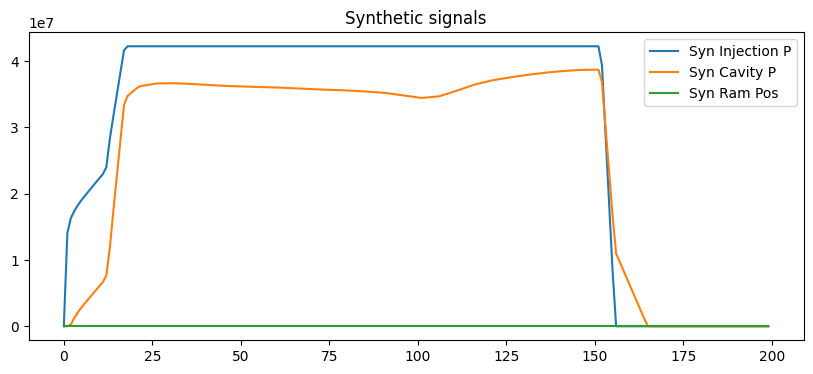

In [44]:
plt.figure(figsize=(10,4))
plt.plot(X_syn[0,:,0], label="Syn Injection P")
plt.plot(X_syn[0,:,1], label="Syn Cavity P")
plt.plot(X_syn[0,:,2], label="Syn Ram Pos")
plt.legend()
plt.title("Synthetic signals")
plt.show()


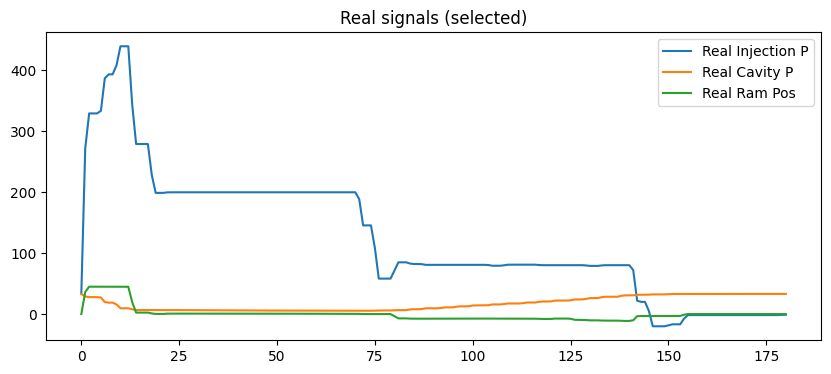

In [46]:
plt.figure(figsize=(10,4))
plt.plot(X_real[0,:,0], label="Real Injection P")
plt.plot(X_real[0,:,1], label="Real Cavity P")
plt.plot(X_real[0,:,2], label="Real Ram Pos")
plt.legend()
plt.title("Real signals (selected)")
plt.show()


In [ ]:
X_real_sel = X_real[:, :, [0, 6, 2]]
print(X_real_sel.shape)
# (438, 181, 3)


(438, 200, 3)


In [50]:
from scipy.signal import resample

X_real_sel = resample(X_real_sel, 200, axis=1)
print(X_real_sel.shape)  # (438, 200, 3)


(438, 200, 3)


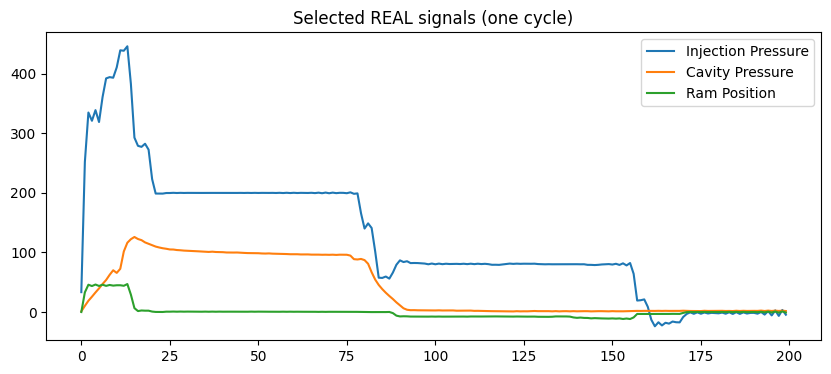

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(X_real_sel[0,:,0], label="Injection Pressure")
plt.plot(X_real_sel[0,:,1], label="Cavity Pressure")
plt.plot(X_real_sel[0,:,2], label="Ram Position")
plt.legend()
plt.title("Selected REAL signals (one cycle)")
plt.show()


Based on signal magnitude and temporal dynamics, three process signals common to both synthetic and real datasets were identified: Injection Pressure, Cavity Pressure, and Ram Position. These signals were selected from the real dataset and resampled to ensure compatibility with the CNN trained on synthetic data.